In [868]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import shap

In [869]:
medical_df = pd.read_csv('bypass_dataset.csv')

In [870]:
medical_df.head()

,TimeStamp,Current_Age,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,...,Involved2Type,Involved2DrugName,Involved3Id,Involved3Type,Involved3DrugName,Involved4Id,Involved4Type,Involved4DrugName,encounterId,recordType
0,2025-04-15 12:22:52.997451 UTC,81,80,Female,180.0,82,22.0,98.0,17.0,22.0,...,LabResult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.504151e+15,PrescriptionModule
1,2025-01-02 08:01:45.649595 UTC,71,70,Female,165.0,68,14.0,176.0,NaN,12.0,...,LabResult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.501021e+15,RegularView
2,2025-01-13 10:17:51.360950 UTC,86,85,Female,168.0,75,30.0,144.0,32.0,19.0,...,LabResult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.501131e+15,RegularView
3,2025-01-01 18:39:46.521618 UTC,44,43,Male,175.0,91,113.0,NaN,25.0,23.0,...,Drug,lamotrigine 100 mg tablet,G1AQ,Ingredient,NaN,NaN,NaN,NaN,2.501011e+15,RegularView
4,2025-04-28 13:21:01.780274 UTC,54,53,Female,184.0,110,75.0,108.0,14.0,14.0,...,Drug,"albuterol sulfate AEROSOL, BREATH ACTIVATED 10...",NaN,NaN,NaN,NaN,NaN,NaN,2.504281e+15,RegularView


In [871]:
medical_df.BypassGroupType.to_list()[105:115]

[nan,
 nan,
 nan,
 nan,
 'Doctor',
 'Doctor',
 'Doctor',
 'Doctor',
 'Doctor',
 'Doctor']

In [872]:
medical_df.shape

(6096, 40)

In [873]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6096 entries, 0 to 6095
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TimeStamp                6096 non-null   object 
 1   Current_Age              6096 non-null   int64  
 2   Alert_Age                6096 non-null   int64  
 3   Gender                   6096 non-null   object 
 4   Height                   6027 non-null   float64
 5   Weight                   6096 non-null   int64  
 6   eGFR                     5735 non-null   float64
 7   LiverALP                 5940 non-null   float64
 8   LiverALT                 5851 non-null   float64
 9   LiverAST                 5776 non-null   float64
 10  Number_Drugs             6096 non-null   int64  
 11  Synopsis                 6096 non-null   object 
 12  Department               4355 non-null   object 
 13  Alert_Group_Title        6096 non-null   object 
 14  AlertType               

In [874]:
medical_df.describe()

,Current_Age,Alert_Age,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,Number_Drugs,Alert_Severity,GCN,PrecautionCode,encounterId
count,6096.000000,6096.000000,6027.000000,6096.000000,5735.000000,5940.000000,5851.000000,5776.000000,6096.000000,4211.000000,5789.000000,595.000000,6.079000e+03
mean,62.698491,61.698491,164.235109,76.511319,74.510201,90.441768,24.757513,23.090478,14.617454,1.823320,41115.339264,970.225210,2.505542e+15
std,20.622025,20.622025,12.746773,20.910188,24.762264,59.214523,25.214999,14.861552,10.682009,0.815898,23017.120313,444.274966,4.208615e+12
min,1.000000,0.000000,52.000000,0.000000,3.000000,18.000000,2.000000,8.000000,1.000000,1.000000,17.000000,21.000000,2.501011e+15
25%,51.000000,50.000000,158.000000,64.000000,58.000000,64.000000,14.000000,16.000000,7.000000,1.000000,20791.000000,762.000000,2.501231e+15
50%,68.000000,67.000000,165.000000,76.000000,77.000000,79.000000,19.000000,20.000000,12.000000,2.000000,45772.000000,845.000000,2.504151e+15
75%,78.000000,77.000000,172.000000,89.000000,91.000000,99.000000,27.000000,25.000000,19.000000,2.000000,62179.000000,1381.000000,2.511091e+15
max,115.000000,114.000000,224.000000,230.000000,171.000000,1119.000000,599.000000,331.000000,186.000000,9.000000,85826.000000,3582.000000,2.511301e+15


Convert timestamp to a datetime object

In [875]:
medical_df.TimeStamp = pd.to_datetime(medical_df.TimeStamp)
medical_df.dtypes

TimeStamp                  datetime64[ns, UTC]
Current_Age                              int64
Alert_Age                                int64
Gender                                  object
Height                                 float64
Weight                                   int64
eGFR                                   float64
LiverALP                               float64
LiverALT                               float64
LiverAST                               float64
Number_Drugs                             int64
Synopsis                                object
Department                              object
Alert_Group_Title                       object
AlertType                               object
Alert_Severity                         float64
Alert_Category                          object
Alert_Description                       object
alert_key                               object
GCN                                    float64
BypassGroupType                         object
BypassReasoni

In [876]:
medical_df.head()

,TimeStamp,Current_Age,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,...,Involved2Type,Involved2DrugName,Involved3Id,Involved3Type,Involved3DrugName,Involved4Id,Involved4Type,Involved4DrugName,encounterId,recordType
0,2025-04-15 12:22:52.997451+00:00,81,80,Female,180.0,82,22.0,98.0,17.0,22.0,...,LabResult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.504151e+15,PrescriptionModule
1,2025-01-02 08:01:45.649595+00:00,71,70,Female,165.0,68,14.0,176.0,NaN,12.0,...,LabResult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.501021e+15,RegularView
2,2025-01-13 10:17:51.360950+00:00,86,85,Female,168.0,75,30.0,144.0,32.0,19.0,...,LabResult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.501131e+15,RegularView
3,2025-01-01 18:39:46.521618+00:00,44,43,Male,175.0,91,113.0,NaN,25.0,23.0,...,Drug,lamotrigine 100 mg tablet,G1AQ,Ingredient,NaN,NaN,NaN,NaN,2.501011e+15,RegularView
4,2025-04-28 13:21:01.780274+00:00,54,53,Female,184.0,110,75.0,108.0,14.0,14.0,...,Drug,"albuterol sulfate AEROSOL, BREATH ACTIVATED 10...",NaN,NaN,NaN,NaN,NaN,NaN,2.504281e+15,RegularView


In [877]:
medical_df = medical_df[medical_df.TimeStamp.dt.month.isin([1, 4, 11]) & medical_df.TimeStamp.dt.year.isin([2025])]

In [878]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6096 entries, 0 to 6095
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   TimeStamp                6096 non-null   datetime64[ns, UTC]
 1   Current_Age              6096 non-null   int64              
 2   Alert_Age                6096 non-null   int64              
 3   Gender                   6096 non-null   object             
 4   Height                   6027 non-null   float64            
 5   Weight                   6096 non-null   int64              
 6   eGFR                     5735 non-null   float64            
 7   LiverALP                 5940 non-null   float64            
 8   LiverALT                 5851 non-null   float64            
 9   LiverAST                 5776 non-null   float64            
 10  Number_Drugs             6096 non-null   int64              
 11  Synopsis                 6096 

### Feature Selection

In [879]:
medical_df.Current_Age.corr(medical_df.Alert_Age)
# Removing correlated features

np.float64(1.0)

In [880]:
features_to_keep = [

    # --- Operational & Environmental Context ---
    'TimeStamp',    # Keep to extract Month (for the task) and Hour (for the model)
    'Department', 
    'recordType',
    
    # --- Patient Physiology (The "Bio" Signal) ---
    'Alert_Age', 
    'Gender', 
    'Height', 
    'Weight', 
    'eGFR', 
    'LiverALP', 
    'LiverALT', 
    'LiverAST',
    
    # --- Alert Context & Severity ---
    'Number_Drugs', 
    'Alert_Group_Title', 
    'Alert_Severity', 
    'Alert_Category',
    
    # --- Interaction Complexity ---
    'Involved1Type', 
    'Involved2Type', 
    'Involved3Type', 
    'Involved4Type',

    # --- Target Variable ---
    'BypassGroupType'
]

In [881]:
medical_df_filtered = medical_df[features_to_keep].copy()

In [882]:
medical_df_filtered

,TimeStamp,Department,recordType,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,Number_Drugs,Alert_Group_Title,Alert_Severity,Alert_Category,Involved1Type,Involved2Type,Involved3Type,Involved4Type,BypassGroupType
0,2025-04-15 12:22:52.997451+00:00,NaN,PrescriptionModule,80,Female,180.0,82,22.0,98.0,17.0,22.0,21,C/I in renal dys.,1.0,DOSAGE,Drug,LabResult,NaN,NaN,NaN
1,2025-01-02 08:01:45.649595+00:00,"משפחה, פנימית וכללית",RegularView,70,Female,165.0,68,14.0,176.0,NaN,12.0,17,C/I in renal dys.,1.0,DDC,Drug,LabResult,NaN,NaN,NaN
2,2025-01-13 10:17:51.360950+00:00,"משפחה, פנימית וכללית",RegularView,85,Female,168.0,75,30.0,144.0,32.0,19.0,31,C/I in renal dys.,1.0,DDC,Drug,LabResult,NaN,NaN,NaN
3,2025-01-01 18:39:46.521618+00:00,"משפחה, פנימית וכללית",RegularView,43,Male,175.0,91,113.0,NaN,25.0,23.0,7,Severe interaction,NaN,DIDBSLD,Drug,Drug,Ingredient,NaN,NaN
4,2025-04-28 13:21:01.780274+00:00,עיניים רשתית,RegularView,53,Female,184.0,110,75.0,108.0,14.0,14.0,24,Severe interaction,2.0,DDI,Drug,Drug,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,2025-11-02 11:34:21.830552+00:00,NaN,RegularView,36,Male,163.0,59,101.0,42.0,15.0,17.0,4,Moderate interaction,NaN,DIDBSLD,Drug,Drug,Ingredient,Ingredient,NaN
6092,2025-01-20 09:46:09.197659+00:00,"משפחה, פנימית וכללית",PrescriptionModule,34,Male,167.0,69,122.0,51.0,9.0,20.0,3,Moderate interaction,NaN,DIDBSLD,Drug,Drug,Ingredient,Ingredient,NaN
6093,2025-01-22 10:44:20.609422+00:00,"משפחה, פנימית וכללית",PrescriptionModule,32,Male,171.0,55,112.0,70.0,22.0,21.0,4,Moderate interaction,NaN,DIDBSLD,Drug,Drug,Ingredient,Ingredient,NaN
6094,2025-11-26 16:44:44.843729+00:00,סוכרת,PrescriptionModule,69,Female,172.0,67,89.0,51.0,34.0,23.0,8,Decreased serum level,NaN,DIDBSLD,Drug,Drug,Ingredient,Ingredient,NaN


Preprocessing: Type Casting, Imputation, and Categorical Encoding

In [883]:
medical_df_filtered = medical_df_filtered.drop_duplicates()
medical_df_filtered.duplicated().sum()

np.int64(0)

In [884]:
medical_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6092 entries, 0 to 6095
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   TimeStamp          6092 non-null   datetime64[ns, UTC]
 1   Department         4352 non-null   object             
 2   recordType         6092 non-null   object             
 3   Alert_Age          6092 non-null   int64              
 4   Gender             6092 non-null   object             
 5   Height             6023 non-null   float64            
 6   Weight             6092 non-null   int64              
 7   eGFR               5731 non-null   float64            
 8   LiverALP           5936 non-null   float64            
 9   LiverALT           5847 non-null   float64            
 10  LiverAST           5773 non-null   float64            
 11  Number_Drugs       6092 non-null   int64              
 12  Alert_Group_Title  6092 non-null   object            

Typecasting

In [885]:
medical_df_filtered = medical_df_filtered.copy()

numeric_cols = ['Alert_Age', 'Height', 'Weight', 'eGFR', 'LiverALP', 'LiverALT', 'LiverAST',
                'Number_Drugs']

categorical_cols = ['Department', 'recordType', 'Alert_Group_Title', 'Alert_Category', 
                    'Involved1Type', 'Involved2Type', 'Involved3Type', 'Involved4Type']

medical_df_filtered[numeric_cols] = medical_df_filtered[numeric_cols].apply(pd.to_numeric, errors='coerce')

medical_df_filtered[categorical_cols] = (
    medical_df_filtered[categorical_cols]
    .fillna("None")
    .astype(str)
)

medical_df_filtered['Gender'] = medical_df_filtered['Gender'].apply(lambda x: 1 if x == 'Male' else 0).astype(int)

In [886]:
medical_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6092 entries, 0 to 6095
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   TimeStamp          6092 non-null   datetime64[ns, UTC]
 1   Department         6092 non-null   object             
 2   recordType         6092 non-null   object             
 3   Alert_Age          6092 non-null   int64              
 4   Gender             6092 non-null   int64              
 5   Height             6023 non-null   float64            
 6   Weight             6092 non-null   int64              
 7   eGFR               5731 non-null   float64            
 8   LiverALP           5936 non-null   float64            
 9   LiverALT           5847 non-null   float64            
 10  LiverAST           5773 non-null   float64            
 11  Number_Drugs       6092 non-null   int64              
 12  Alert_Group_Title  6092 non-null   object            

In [887]:
medical_df_filtered.head()

,TimeStamp,Department,recordType,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,Number_Drugs,Alert_Group_Title,Alert_Severity,Alert_Category,Involved1Type,Involved2Type,Involved3Type,Involved4Type,BypassGroupType
0,2025-04-15 12:22:52.997451+00:00,None,PrescriptionModule,80,0,180.0,82,22.0,98.0,17.0,22.0,21,C/I in renal dys.,1.0,DOSAGE,Drug,LabResult,None,None,NaN
1,2025-01-02 08:01:45.649595+00:00,"משפחה, פנימית וכללית",RegularView,70,0,165.0,68,14.0,176.0,NaN,12.0,17,C/I in renal dys.,1.0,DDC,Drug,LabResult,None,None,NaN
2,2025-01-13 10:17:51.360950+00:00,"משפחה, פנימית וכללית",RegularView,85,0,168.0,75,30.0,144.0,32.0,19.0,31,C/I in renal dys.,1.0,DDC,Drug,LabResult,None,None,NaN
3,2025-01-01 18:39:46.521618+00:00,"משפחה, פנימית וכללית",RegularView,43,1,175.0,91,113.0,NaN,25.0,23.0,7,Severe interaction,NaN,DIDBSLD,Drug,Drug,Ingredient,None,NaN
4,2025-04-28 13:21:01.780274+00:00,עיניים רשתית,RegularView,53,0,184.0,110,75.0,108.0,14.0,14.0,24,Severe interaction,2.0,DDI,Drug,Drug,None,None,NaN


Outliers

In [909]:
# numeric_cols = medical_df_filtered.select_dtypes(include=['number']).columns
# fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(10, 4 * len(numeric_cols)))

# for i, col in enumerate(numeric_cols):
#     axes[i].boxplot(medical_df_filtered[col].dropna(), vert=False)
#     axes[i].set_title(f'Outlier Detection: {col}', fontsize=14)
#     axes[i].set_xlabel('Value')
#     axes[i].grid(True, linestyle='--', alpha=0.6)

# plt.tight_layout()

In [889]:
# medical_df_filtered.loc[medical_df_filtered.Height<100, :].head()

,TimeStamp,Department,recordType,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,Number_Drugs,Alert_Group_Title,Alert_Severity,Alert_Category,Involved1Type,Involved2Type,Involved3Type,Involved4Type,BypassGroupType
349,2025-11-20 18:12:52.016504+00:00,רפואת ילדים,RegularView,4,1,98.0,18,NaN,216.0,27.0,25.0,13,Severe interaction,2.0,DDI,Drug,Drug,Drug,Drug,Doctor
445,2025-04-24 07:47:03.328355+00:00,None,RegularView,6,0,95.0,13,NaN,NaN,33.0,40.0,10,Severe interaction,2.0,DDI,Drug,Drug,Drug,Drug,Doctor
1080,2025-01-14 12:14:57.881013+00:00,רפואת ילדים,RegularView,5,1,91.0,20,NaN,240.0,488.0,222.0,9,Severe interaction,2.0,DDI,Drug,Drug,Drug,Drug,Doctor
1213,2025-01-10 06:58:31.535376+00:00,פסיכיאטריה למבוגרים,PrescriptionModule,37,0,72.0,62,112.0,67.0,57.4,29.5,6,Decreased serum level,NaN,DIDBSLD,Drug,Drug,Ingredient,None,Doctor
1290,2025-01-29 10:02:08.655438+00:00,ילדים,PrescriptionModule,3,0,88.0,16,NaN,NaN,NaN,NaN,9,Decreased serum level,NaN,DIDBSLD,Drug,Drug,None,None,Doctor


In [890]:
medical_df_filtered['is_night_shift'] = np.where(
    (medical_df_filtered['TimeStamp'].dt.hour >= 23) | 
    (medical_df_filtered['TimeStamp'].dt.hour < 7), 
    1, 0
)

day_raw = medical_df_filtered['TimeStamp'].dt.dayofweek
medical_df_filtered['is_weekend'] = (day_raw >= 5).astype(int)

medical_df_filtered = medical_df_filtered.drop(columns='TimeStamp')

In [891]:
medical_df_filtered.describe()

,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,Number_Drugs,Alert_Severity,is_night_shift,is_weekend
count,6092.000000,6092.000000,6023.000000,6092.000000,5731.000000,5936.000000,5847.000000,5773.000000,6092.000000,4208.000000,6092.000000,6092.000000
mean,61.698129,0.563362,164.232940,76.514445,74.515617,90.446277,24.761965,23.090525,14.612443,1.823669,0.123933,0.238017
std,20.618749,0.496010,12.749771,20.907697,24.751524,59.230247,25.222633,14.865192,10.680430,0.815986,0.329532,0.425905
min,0.000000,0.000000,52.000000,0.000000,3.000000,18.000000,2.000000,8.000000,1.000000,1.000000,0.000000,0.000000
25%,50.000000,0.000000,158.000000,64.000000,58.000000,64.000000,14.000000,16.000000,7.000000,1.000000,0.000000,0.000000
50%,67.000000,1.000000,165.000000,76.000000,77.000000,79.000000,19.000000,20.000000,12.000000,2.000000,0.000000,0.000000
75%,77.000000,1.000000,172.000000,89.000000,91.000000,99.000000,27.000000,25.000000,19.000000,2.000000,0.000000,0.000000
max,114.000000,1.000000,224.000000,230.000000,171.000000,1119.000000,599.000000,331.000000,186.000000,9.000000,1.000000,1.000000


In [892]:
medical_df_filtered['Weight'] = medical_df_filtered['Weight'].replace(0, np.nan)

Splitting before imputations, to prevent train-test leakage

In [893]:
# target + safe mapping
y = (medical_df_filtered["BypassGroupType"] == "Doctor").astype(int)
X = medical_df_filtered.drop(columns=["BypassGroupType"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Na Imputation

In [894]:
for _df in (X_train, X_test):
    _df["Alert_Severity"] = _df["Alert_Severity"].fillna(0)
    _df["Alert_Severity"] = _df["Alert_Severity"].replace({5.0: 4.0, 9.0: 4.0})

Group specific imputation of NA values to Height and Age columns

In [895]:
# --- Group-specific median imputation for Height/Weight (fit on train, apply to test) ---
for _df in (X_train, X_test):
    _df["Age_Group"] = pd.cut(
        _df["Alert_Age"],
        bins=[-1, 20, 40, 60, 80, 150],
        labels=["0-20", "21-40", "41-60", "61-80", "80+"]
    )

cols_to_impute = ["Height", "Weight"]

group_medians = X_train.groupby(["Gender", "Age_Group"], observed=True)[cols_to_impute].median()
gender_medians = X_train.groupby("Gender", observed=True)[cols_to_impute].median()
global_medians = X_train[cols_to_impute].median()

for col in cols_to_impute:
    for _df in (X_train, X_test):
        gm = _df.set_index(["Gender", "Age_Group"]).index.map(group_medians[col])
        gm = pd.Series(gm, index=_df.index)
        _df[col] = _df[col].fillna(gm)

        gmed = _df["Gender"].map(gender_medians[col])
        _df[col] = _df[col].fillna(gmed)

        _df[col] = _df[col].fillna(global_medians[col])

X_train.drop(columns=["Age_Group"], inplace=True)
X_test.drop(columns=["Age_Group"], inplace=True)

In [896]:
lab_features = ["eGFR", "LiverALP", "LiverALT", "LiverAST"]

# Missing flags (safe, do separately on train & test)
for _df in (X_train, X_test):
    missing_flags = _df[lab_features].isna().astype(int).add_suffix("_is_missing")
    _df[missing_flags.columns] = missing_flags

# Train-only medians
lab_medians = X_train[lab_features].median()

# Apply to both
X_train[lab_features] = X_train[lab_features].fillna(lab_medians)
X_test[lab_features]  = X_test[lab_features].fillna(lab_medians)

print("Total remaining NaNs (train):", int(X_train.isna().sum().sum()))
print("Total remaining NaNs (test):", int(X_test.isna().sum().sum()))

Total remaining NaNs (train): 0
Total remaining NaNs (test): 0


One Hot Encoding

In [897]:
translation_map = {
    "כירורגיה אורתופדית": "Orthopedic Surgery",
    "משפחה, פנימית וכללית": "Internal Medicine",
    "נשים - גינקולוגיה": "OBGYN",
    "עיניים": "Ophthalmology",
    "פסיכיאטריה למבוגרים": "Adult Psychiatry",
    "רפואת ילדים": "Pediatrics",
}

# Categorical columns list (prefer explicit list you already have)
cat_cols = X_train.select_dtypes(include=["object"]).columns

# 1) Apply translation on BOTH (row-wise)
for _df in (X_train, X_test):
    if "Department" in _df.columns:
        _df["Department"] = _df["Department"].replace(translation_map)

# 2) Learn rare categories on TRAIN only, apply to both
rare_map = {}  # store per column so you can reuse in CV too

for col in cat_cols:
    counts = X_train[col].value_counts()
    unique_count = len(counts)

    if unique_count > 10:
        threshold = len(X_train) * 0.01  # use TRAIN size
        rare_categories = counts[counts < threshold].index
        rare_map[col] = set(rare_categories)

        X_train[col] = X_train[col].replace(rare_categories, "Other")
        X_test[col]  = X_test[col].replace(rare_categories, "Other")

        print(f"Lumped {len(rare_categories)} rare categories into 'Other' for: {col}")

print("\nTop 5 values in Department after lumping (train):")
print(X_train["Department"].value_counts().head())

Lumped 179 rare categories into 'Other' for: Department
Lumped 11 rare categories into 'Other' for: Alert_Group_Title
Lumped 3 rare categories into 'Other' for: Alert_Category

Top 5 values in Department after lumping (train):
Department
Internal Medicine    2047
None                 1422
Other                 981
Pediatrics            125
Ophthalmology         101
Name: count, dtype: int64


In [898]:
cols_to_encode = [
    "Department", "recordType", "Alert_Group_Title", "Alert_Category",
    "Involved1Type", "Involved2Type", "Involved3Type", "Involved4Type",
    "Alert_Severity",
]

X_train = pd.get_dummies(X_train, columns=cols_to_encode, dtype=int)
X_test  = pd.get_dummies(X_test,  columns=cols_to_encode, dtype=int)

# Align columns so test has exactly train's feature space
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [899]:
X_train

,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,Number_Drugs,is_night_shift,...,Involved4Type_Drug,Involved4Type_Ingredient,Involved4Type_LabResult,Involved4Type_None,Involved4Type_Patient Factor,Alert_Severity_0.0,Alert_Severity_1.0,Alert_Severity_2.0,Alert_Severity_3.0,Alert_Severity_4.0
5851,72,0,177.0,95.0,91.0,132.0,14.0,12.0,15,0,...,0,0,0,1,0,1,0,0,0,0
1991,37,0,194.0,106.0,110.0,64.0,28.0,20.0,2,0,...,0,0,0,1,0,1,0,0,0,0
3736,63,1,160.0,85.0,94.0,112.0,23.0,14.0,19,0,...,0,0,0,1,0,0,1,0,0,0
423,73,1,163.0,66.0,56.0,73.0,13.0,16.0,16,0,...,0,0,0,1,0,0,0,1,0,0
5501,81,1,158.0,80.0,41.0,99.0,19.0,20.0,15,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,34,1,166.0,75.0,115.0,118.0,19.0,14.0,10,0,...,0,1,0,0,0,1,0,0,0,0
5420,79,0,187.0,116.0,39.0,79.0,25.0,22.0,17,0,...,0,0,0,1,0,0,0,0,1,0
4429,89,0,164.0,82.0,69.0,809.0,14.0,40.0,35,0,...,0,0,0,1,0,0,1,0,0,0
721,96,1,163.0,56.0,39.0,74.0,14.0,17.0,31,0,...,0,0,0,1,0,0,0,1,0,0


In [900]:
X_train.shape

(4873, 78)

In [901]:
X_train.head()

,Alert_Age,Gender,Height,Weight,eGFR,LiverALP,LiverALT,LiverAST,Number_Drugs,is_night_shift,...,Involved4Type_Drug,Involved4Type_Ingredient,Involved4Type_LabResult,Involved4Type_None,Involved4Type_Patient Factor,Alert_Severity_0.0,Alert_Severity_1.0,Alert_Severity_2.0,Alert_Severity_3.0,Alert_Severity_4.0
5851,72,0,177.0,95.0,91.0,132.0,14.0,12.0,15,0,...,0,0,0,1,0,1,0,0,0,0
1991,37,0,194.0,106.0,110.0,64.0,28.0,20.0,2,0,...,0,0,0,1,0,1,0,0,0,0
3736,63,1,160.0,85.0,94.0,112.0,23.0,14.0,19,0,...,0,0,0,1,0,0,1,0,0,0
423,73,1,163.0,66.0,56.0,73.0,13.0,16.0,16,0,...,0,0,0,1,0,0,0,1,0,0
5501,81,1,158.0,80.0,41.0,99.0,19.0,20.0,15,0,...,0,0,0,1,0,1,0,0,0,0


In [902]:
# check_cols = ['Alert_Age', 'Height', 'Weight', 'eGFR', 'LiverALP', 'LiverALT', 'LiverAST', 'Number_Drugs']

# skew_values = medical_df_filtered[check_cols].skew().sort_values(ascending=False)
# print(skew_values)

# Reduce skewness

# log_cols = ['LiverALT', 'LiverAST', 'LiverALP', 'Number_Drugs']

# for col in log_cols:
#     medical_df_filtered[col] = np.log1p(medical_df_filtered[col])

In [905]:
y_train.value_counts()

# 3:1 class imbalance

# 1 = Bypassed by a doctor.

BypassGroupType
1    3596
0    1277
Name: count, dtype: int64

### Model Selection Rationale

For this clinical behavioral dataset, **Random Forest** was selected over Linear Models (Logistic Regression) and Boosting algorithms (XGBoost) for three primary reasons:

- Linear models fail on this non-linearity of biomodal features like Height and Weight without arbitrary binning; decision trees natively branch these populations.

- Clinical labs feature extreme natural outliers. Because trees split on rank rather than spatial distance, we could skip destructive Log-Transforms and Z-scores. The model trains on-and explains decisions using-the exact, raw numbers a doctor sees in the EMR.

3. **Robustness to Human Noise:** We are predicting *human behavior* (the decision to bypass), which is inherently noisy. While sequential boosting algorithms (XGBoost) are prone to overfitting this noise, Random Forest's independent bagging approach stabilizes the variance and provides highly reliable **Feature Importance** metrics for stakeholder review.

### Modelling

In [906]:
# Global 80/20 Stratified Split

# class_weight='balanced': automatically adjusts the weight of each class inversely proportional to its frequency.

# n_estimators=100: The default value. adding more trees won't overfit like boosted methods,
# but we can try a few different values (might slow computation time).

# random_state=42: Guarantee model reproducibility.

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# This is to show the model is stable and independent of the split
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

print(f"CV ROC-AUC Scores across 5 folds: {cv_scores}")
print(f"Average CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Actuall training on the 80% part
rf_model.fit(X_train, y_train) 

CV ROC-AUC Scores across 5 folds: [0.9459563  0.94198757 0.92687636 0.93500505 0.94656522]
Average CV ROC-AUC: 0.939 (+/- 0.015)


RandomForestClassifier(class_weight='balanced', random_state=42)

Evaluation

Final Test ROC-AUC: 0.943

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       319
           1       0.92      0.95      0.93       900

    accuracy                           0.90      1219
   macro avg       0.87      0.85      0.86      1219
weighted avg       0.89      0.90      0.90      1219



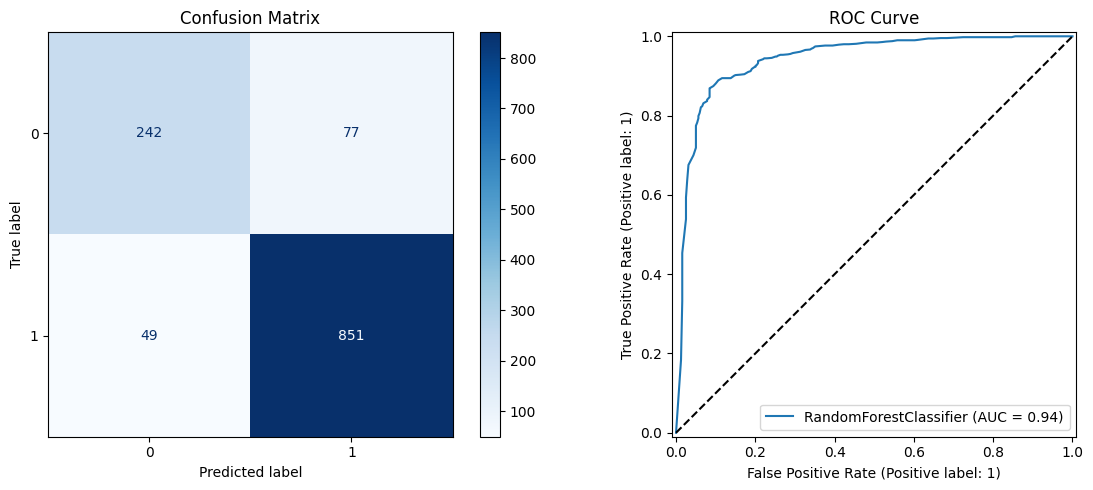

In [907]:
y_prob = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)

print(f"Final Test ROC-AUC: {roc_auc_score(y_test, y_prob):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues', ax=ax1)
ax1.set_title("Confusion Matrix")

RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax2.set_title("ROC Curve")

plt.tight_layout()
plt.show()

Explanability

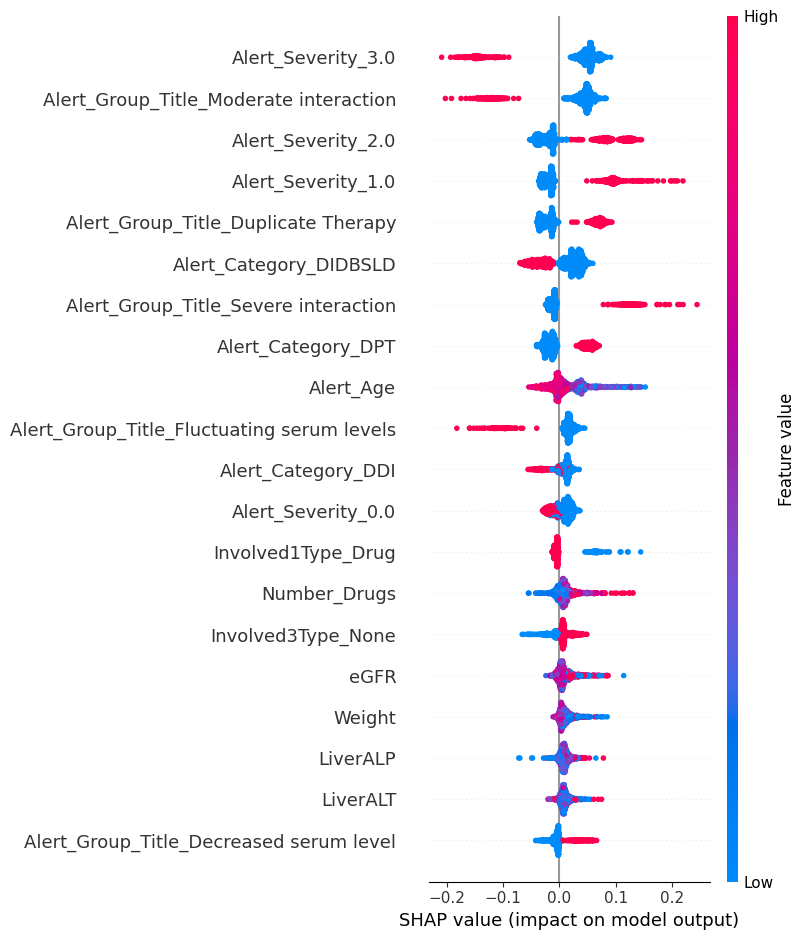

In [908]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap_values_class_1 = shap_values[:, :, 1]

# For every single patient in the test set, 
# how much did each feature push the model towards or away from a Bypass prediction?

shap.summary_plot(shap_values_class_1, X_test)